# Калибровка классификаторов
[Видео на эту тему](https://www.youtube.com/watch?v=IL7sWMOazXQ)

[Как оценивать вероятности](https://education.yandex.ru/handbook/ml/article/kak-ocenivat-veroyatnosti)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

import seaborn as sns

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
import optuna

from tqdm import tqdm

%matplotlib inline

D:\Dev\jupyter\projects\Data Science\venvs\hardml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('./data/train.csv')
data.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

In [4]:
TARGET = 'target'
FEATURES = [col for col in data.columns if data[col].dtype != 'object' and col not in [TARGET, 'id']]

data = data[FEATURES+[TARGET]]
data.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,target
0,2,2,5,1,0,0,1,0,0,0,...,1,5,8,0,1,1,0,0,1,0
1,1,1,7,0,0,0,0,1,0,0,...,1,1,9,0,1,1,0,1,0,0
2,5,4,9,1,0,0,0,1,0,0,...,2,7,7,0,1,1,0,1,0,0
3,0,1,2,0,0,1,0,0,0,0,...,2,4,9,0,0,0,0,0,0,0
4,0,2,0,1,0,1,0,0,0,0,...,1,1,3,0,0,0,1,1,0,0


# Просто представим что там был крутой EDA и Feature engineering и мы обучаем классную модель, здесь речь все равно не об этом

In [5]:
x_train, x_val, y_train, y_val = train_test_split(data[FEATURES], data[TARGET], test_size=0.4, stratify=data[TARGET], random_state=123)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, stratify=y_val, random_state=123)

print('TRAIN', x_train.shape, np.sum(y_train)/len(y_train))
print('VAL', x_val.shape, np.sum(y_val)/len(y_val))
print('TEST', x_test.shape, np.sum(y_test)/len(y_test))

TRAIN (357127, 57) 0.03644641822096901
VAL (119042, 57) 0.03644932040792325
TEST (119043, 57) 0.036449014221751806


In [6]:
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    model = LGBMClassifier(**param)
    model.fit(x_train, y_train)

    preds = model.predict_proba(x_val)[:, 1]
    return roc_auc_score(y_val, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-07-22 23:34:13,222] A new study created in memory with name: no-name-527a3a7b-0b25-4fe9-81e4-941943e5f1d2
[I 2024-07-22 23:34:15,751] Trial 0 finished with value: 0.6087561383340516 and parameters: {'lambda_l1': 1.111372632787054e-06, 'lambda_l2': 0.008184856072759249, 'num_leaves': 162, 'feature_fraction': 0.9321194469089518, 'bagging_fraction': 0.6734255083956082, 'bagging_freq': 1, 'min_child_samples': 59}. Best is trial 0 with value: 0.6087561383340516.
[I 2024-07-22 23:34:19,533] Trial 1 finished with value: 0.6182912038708135 and parameters: {'lambda_l1': 8.892532939937938, 'lambda_l2': 0.0033062757969069814, 'num_leaves': 236, 'feature_fraction': 0.9666757137787307, 'bagging_fraction': 0.5328622959216828, 'bagging_freq': 4, 'min_child_samples': 21}. Best is trial 1 with value: 0.6182912038708135.
[I 2024-07-22 23:34:21,856] Trial 2 finished with value: 0.628211008039266 and parameters: {'lambda_l1': 2.303665828338776e-05, 'lambda_l2': 1.4486686227753232e-05, 'num_leaves'

In [7]:
study.best_params

{'lambda_l1': 0.05294323584757407,
 'lambda_l2': 4.648431748339859,
 'num_leaves': 14,
 'feature_fraction': 0.7891058609795729,
 'bagging_fraction': 0.971972673909783,
 'bagging_freq': 4,
 'min_child_samples': 87}

In [8]:
model = LGBMClassifier(**study.best_params)
model.fit(x_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.7891058609795729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7891058609795729
[LightGBM] [Warning] lambda_l1 is set=0.05294323584757407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05294323584757407
[LightGBM] [Warning] lambda_l2 is set=4.648431748339859, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.648431748339859
[LightGBM] [Warning] bagging_fraction is set=0.971972673909783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.971972673909783
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7891058609795729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7891058609795729
[LightGBM] [Warning] lambda_l1 is set=0.05294323584757407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05294323584757407
[LightGBM] [Warning] lambda_l2 is set

LGBMClassifier(bagging_fraction=0.971972673909783, bagging_freq=4,
               feature_fraction=0.7891058609795729,
               lambda_l1=0.05294323584757407, lambda_l2=4.648431748339859,
               min_child_samples=87, num_leaves=14)

[LightGBM] [Warning] feature_fraction is set=0.7891058609795729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7891058609795729
[LightGBM] [Warning] lambda_l1 is set=0.05294323584757407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05294323584757407
[LightGBM] [Warning] lambda_l2 is set=4.648431748339859, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.648431748339859
[LightGBM] [Warning] bagging_fraction is set=0.971972673909783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.971972673909783
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


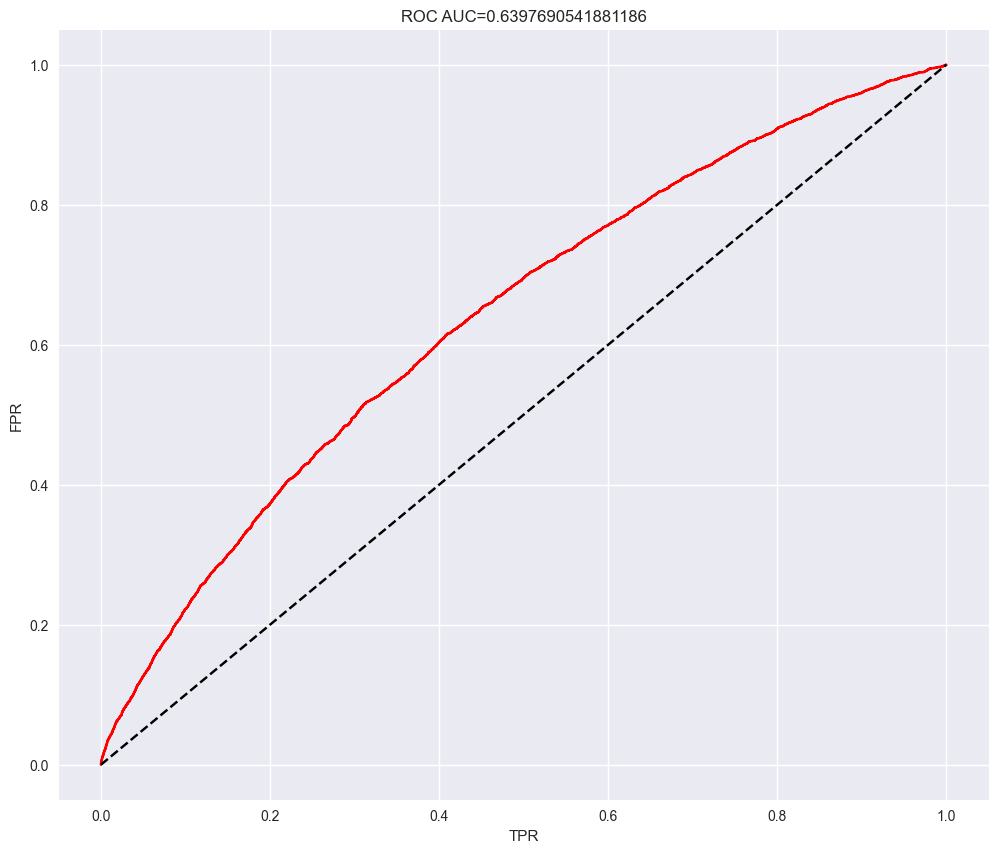

In [9]:
preds = model.predict_proba(x_val)[:, 1]

tpr, fpr, thresholds = roc_curve(y_val, preds)

plt.figure(figsize=(12, 10))
plt.plot(tpr, fpr, color='red')
plt.plot([0, 1], [0, 1], '--', color='black')

plt.xlabel('TPR')
plt.ylabel('FPR')
plt.title(f'ROC AUC={roc_auc_score(y_val, preds)}');

In [10]:
preds_test = model.predict_proba(x_test)[:, 1]
roc_auc_score(y_test, preds_test)

[LightGBM] [Warning] feature_fraction is set=0.7891058609795729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7891058609795729
[LightGBM] [Warning] lambda_l1 is set=0.05294323584757407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05294323584757407
[LightGBM] [Warning] lambda_l2 is set=4.648431748339859, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.648431748339859
[LightGBM] [Warning] bagging_fraction is set=0.971972673909783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.971972673909783
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


0.6386666928564386

# Как он хорош

In [11]:
from sklearn.calibration import calibration_curve

In [12]:
prob_true, prob_pred = calibration_curve(y_val, preds, n_bins=100, strategy='quantile')

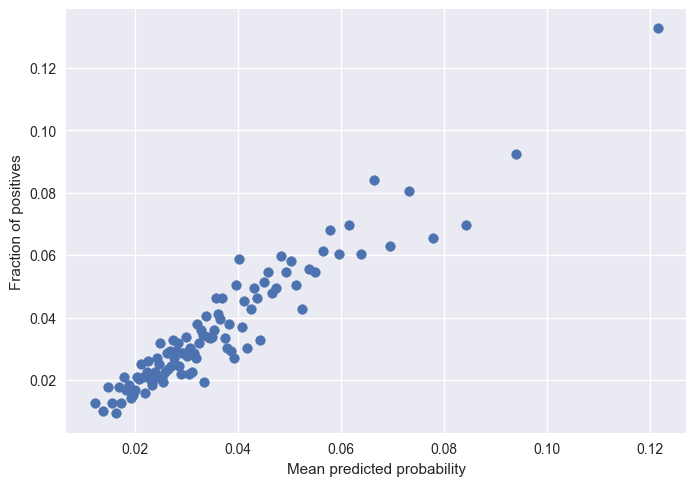

In [13]:
plt.scatter(prob_pred, prob_true)
# plt.plot([0, 1], [0, 1], '--', color='black', lw=1.)
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives');

In [14]:
def give_ece_data(preds, bins, y_valid):
    sorted_ind = np.argsort(preds)
    predicted_bins = [[] for _ in range(bins)]
    actual_counters = [[] for _ in range(bins)]
    counters = [[] for _ in range(bins)]
    index = 0
    length_array = len(sorted_ind)
    step = 1.*length_array//bins
    for _ in range(bins):
        current = int(step*index)
        next_ = int(step*(index+1))
        predicted_bins[index] = np.mean(preds[sorted_ind[current:next_]])
        actual_counters[index] = np.mean(y_valid[sorted_ind[current:next_]])
        counters[index] = len(y_valid[sorted_ind[current:next_]])
        index += 1
    return predicted_bins, actual_counters, counters

0.004706245863147395


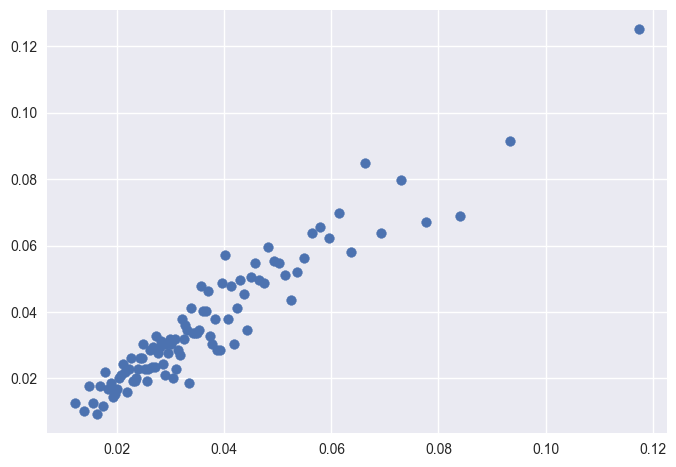

In [15]:
predicted_bins, actual_counters, counters = give_ece_data(preds, 100, y_val.values)

plt.scatter(predicted_bins, actual_counters)
ece = 0
for i in range(100):
    ece +=  counters[i]*np.abs((predicted_bins[i] - actual_counters[i]))
ece /= len(y_val)
print(ece)

# Почти лежат на одной прямой, он неплохо откалиброван из коробки, плюс expected calibration error (ece) небольшой

# Попробуем с другими параметрами

In [16]:
parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

model = LGBMClassifier(**parameters)
model.fit(x_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20


D:\Dev\jupyter\projects\Data Science\venvs\hardml\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: Found 'application' in params. Will use it instead of 'objective' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'objective' argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20


LGBMClassifier(application='binary', bagging_fraction=0.5, bagging_freq=20,
               boosting='gbdt', feature_fraction=0.5, is_unbalance='true',
               learning_rate=0.05, metric='auc', objective='binary', verbose=0)

D:\Dev\jupyter\projects\Data Science\venvs\hardml\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: Found 'application' in params. Will use it instead of 'objective' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'objective' argument")


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20


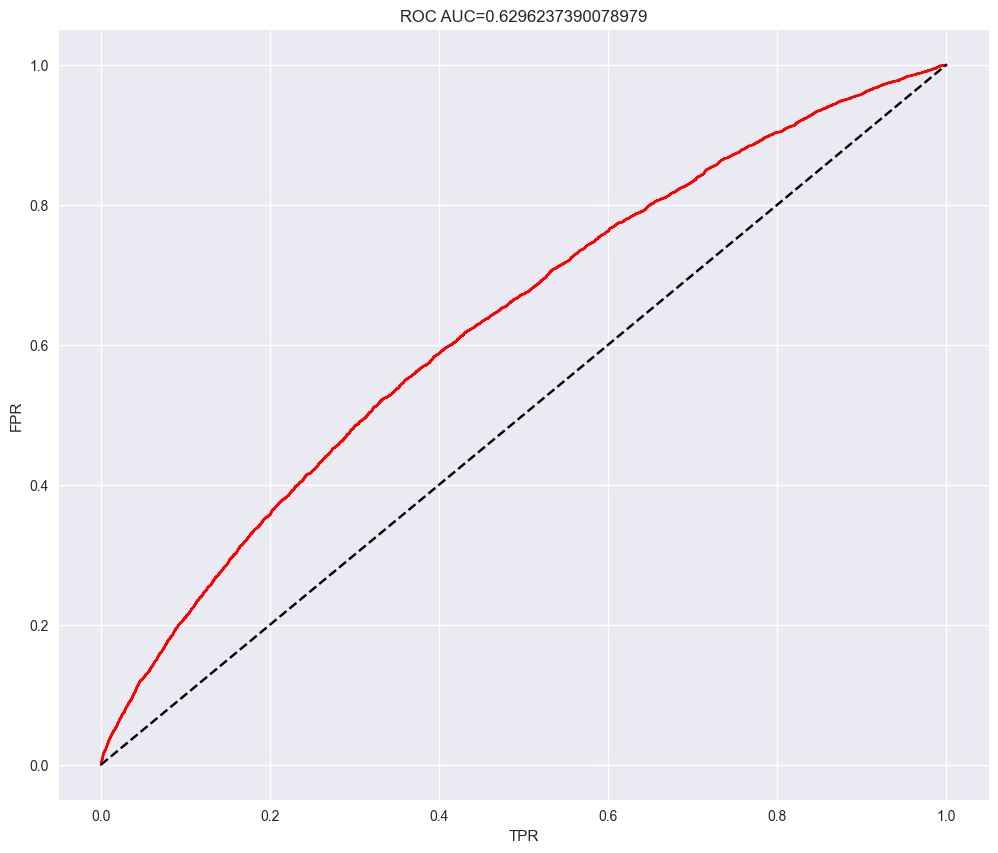

In [17]:
preds = model.predict_proba(x_val)[:, 1]

tpr, fpr, thresholds = roc_curve(y_val, preds)

plt.figure(figsize=(12, 10))
plt.plot(tpr, fpr, color='red')
plt.plot([0, 1], [0, 1], '--', color='black')

plt.xlabel('TPR')
plt.ylabel('FPR')
plt.title(f'ROC AUC={roc_auc_score(y_val, preds)}');

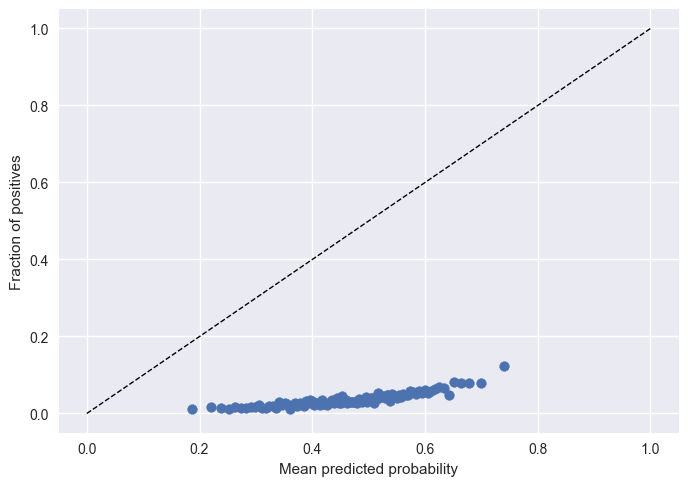

In [18]:
prob_true, prob_pred = calibration_curve(y_val, preds, n_bins=100, strategy='quantile')

plt.scatter(prob_pred, prob_true)
plt.plot([0, 1], [0, 1], '--', color='black', lw=1.)
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives');

0.4247405144022071


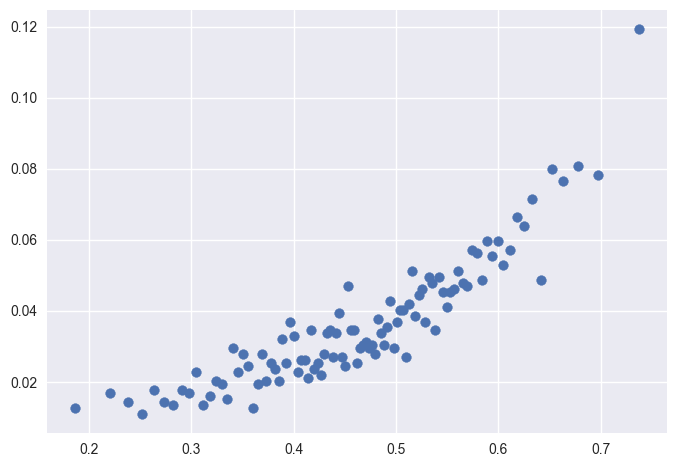

In [19]:
predicted_bins, actual_counters, counters = give_ece_data(preds, 100, y_val.values)

plt.scatter(predicted_bins, actual_counters)
ece = 0
for i in range(100):
    ece +=  counters[i]*np.abs((predicted_bins[i] - actual_counters[i]))
ece /= len(y_val)
print(ece)

# Видим картину ужасной калибровки, модель через чур уверена в себе, выдает скор 0.7, а на самом деле там в районе 0.1 доли единиц
P.S. Интересное наблюдение: если отключить параметр is_unbalance, то с калибровкой дело станет лучше. В документации упоминается об этом "it will also result in poor estimates of the individual class probabilities" (https://lightgbm.readthedocs.io/en/latest/Parameters.html)

# Попробуем откалибровать.
[Проблема калибровки уверенности](https://alexanderdyakonov.wordpress.com/2020/03/27/%D0%BF%D1%80%D0%BE%D0%B1%D0%BB%D0%B5%D0%BC%D0%B0-%D0%BA%D0%B0%D0%BB%D0%B8%D0%B1%D1%80%D0%BE%D0%B2%D0%BA%D0%B8-%D1%83%D0%B2%D0%B5%D1%80%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8/)

# Калибровка с помощью логистической регрессии

In [20]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()

preds_val = model.predict_proba(x_val)[:, 1]
log_reg.fit(preds_val.reshape(-1, 1), y_val)  # обучаем логистическую регрессию на скорах, выдаваемых моделью, на отдельной выборке

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20


D:\Dev\jupyter\projects\Data Science\venvs\hardml\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: Found 'application' in params. Will use it instead of 'objective' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'objective' argument")


LogisticRegression()

0.004527691707261012


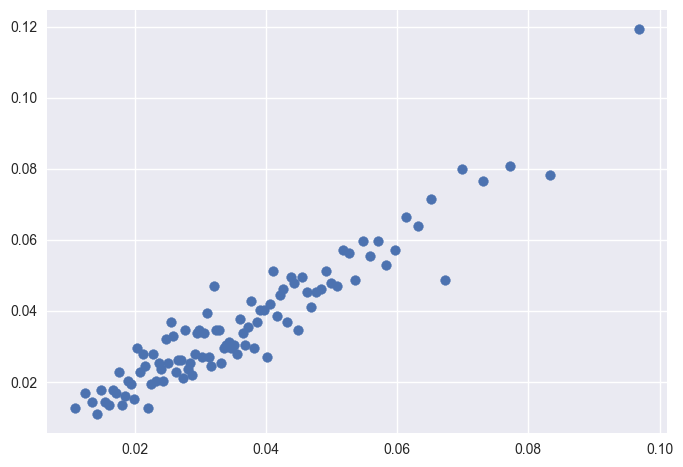

In [21]:
predicted_bins, actual_counters, counters = give_ece_data(log_reg.predict_proba(preds_val.reshape(-1, 1))[:, 1], 100, y_val.values)

plt.scatter(predicted_bins, actual_counters)
ece = 0
for i in range(100):
    ece +=  counters[i]*np.abs((predicted_bins[i] - actual_counters[i]))
ece /= len(y_val)
print(ece)

# Посмотрим как на тесте

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20


D:\Dev\jupyter\projects\Data Science\venvs\hardml\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: Found 'application' in params. Will use it instead of 'objective' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'objective' argument")


0.0041166081346770715


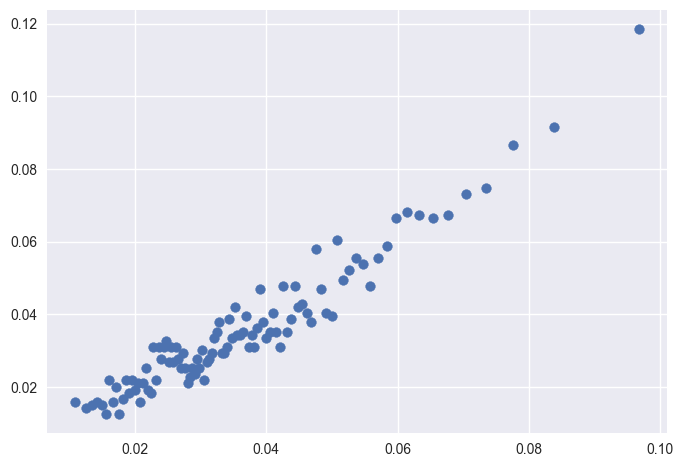

In [22]:
preds_test = model.predict_proba(x_test)[:, 1]

predicted_bins, actual_counters, counters = give_ece_data(log_reg.predict_proba(preds_test.reshape(-1, 1))[:, 1], 100, y_test.values)

plt.scatter(predicted_bins, actual_counters)
ece = 0
for i in range(100):
    ece +=  counters[i]*np.abs((predicted_bins[i] - actual_counters[i]))
ece /= len(preds_test)
print(ece)

In [23]:
roc_auc_score(y_val, preds_val), roc_auc_score(y_val, log_reg.predict_proba(preds_val.reshape(-1, 1))[:, 1])

(0.6296237390078979, 0.6296237390078979)

In [24]:
roc_auc_score(y_test, preds_test), roc_auc_score(y_test, log_reg.predict_proba(preds_test.reshape(-1, 1))[:, 1])

(0.6299135699752826, 0.6299135699752826)

# Видно, что и на тесте, который не видела ни одна модель при обучении все стало намного лучше

# Изотоническая регрессия

In [48]:
from sklearn.isotonic import IsotonicRegression

iso_reg = IsotonicRegression(out_of_bounds='clip')

preds_val = model.predict_proba(x_val)[:, 1]
iso_reg.fit(preds_val, y_val)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20


D:\Dev\jupyter\projects\Data Science\venvs\hardml\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: Found 'application' in params. Will use it instead of 'objective' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'objective' argument")


IsotonicRegression(out_of_bounds='clip')

0.0033291618866684316


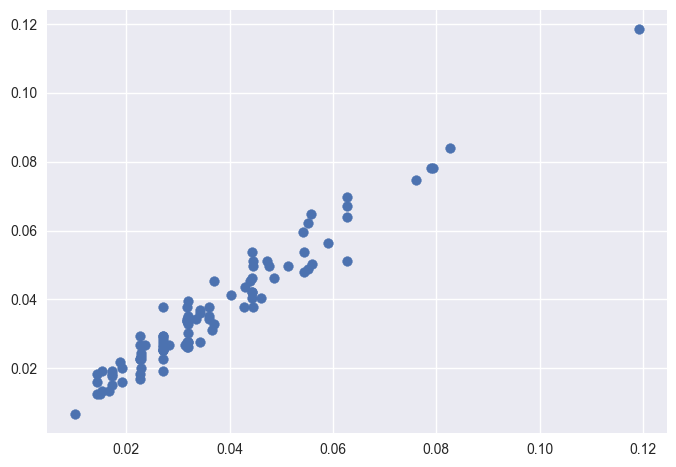

In [49]:
predicted_bins, actual_counters, counters = give_ece_data(iso_reg.predict(preds_val), 100, y_val.values)

plt.scatter(predicted_bins, actual_counters)
ece = 0
for i in range(100):
    ece +=  counters[i]*np.abs((predicted_bins[i] - actual_counters[i]))
ece /= len(y_val)
print(ece)

0.004224143267042254


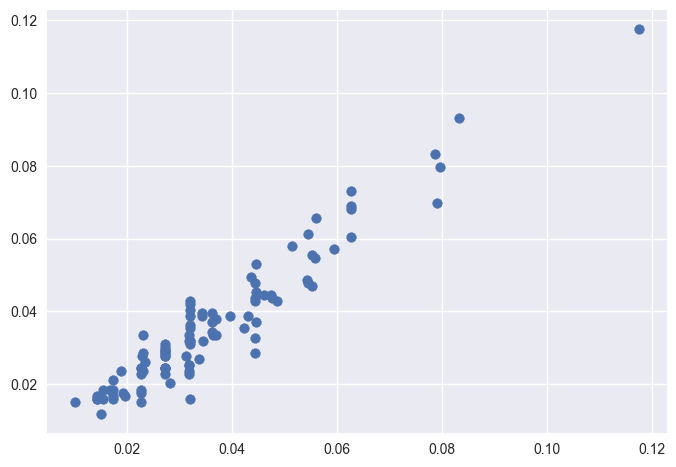

In [50]:
predicted_bins, actual_counters, counters = give_ece_data(iso_reg.predict(preds_test), 100, y_test.values)

plt.scatter(predicted_bins, actual_counters)
ece = 0
for i in range(100):
    ece +=  counters[i]*np.abs((predicted_bins[i] - actual_counters[i]))
ece /= len(y_test)
print(ece)

In [51]:
roc_auc_score(y_val, preds_val), roc_auc_score(y_val, iso_reg.predict(preds_val))

(0.6296237390078979, 0.6316250648485309)

In [52]:
roc_auc_score(y_test, preds_test), roc_auc_score(y_test, iso_reg.predict(preds_test))

(0.6299135699752826, 0.6299274246887873)

# Деревья калибровки

In [25]:
# обучаем дерево на исходных данных
tree_model = DecisionTreeClassifier(min_samples_leaf=1700,max_depth=5)
tree_model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=1700)

In [26]:
TREE = tree_model.tree_
indexes = TREE.apply(x_val.values.astype(np.float32))  # находим в какой ноде будет каждый элемент валидационного сета
predicts_from_model = model.predict_proba(x_val)[:, 1].reshape((-1,1))  # предсказываем скор исходной модели

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20


D:\Dev\jupyter\projects\Data Science\venvs\hardml\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: Found 'application' in params. Will use it instead of 'objective' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'objective' argument")


In [27]:
def transform(x):
    return np.log(x/(1-x))

# авторы предлагают трансформировать перед обучением

In [28]:
log_reg_dict = {}
nodes = np.unique(indexes)  # для каждой ноды обучем логистическую регрессию
for node in tqdm(nodes):
    log_reg = LogisticRegression()
    log_reg.fit(transform(predicts_from_model[indexes==node]), y_val[indexes==node])  # обучаем только на тех, которые попали в этот лист
    log_reg_dict[node] = log_reg

100%|█████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 217.37it/s]


## Дальше то же самое можем проделать для предсказания откалиброванных вероятностей

In [29]:
predicts_calibrated = np.zeros_like(predicts_from_model)

for node in tqdm(log_reg_dict.keys()):
    predicts_calibrated[indexes==node] = log_reg_dict[node].\
        predict_proba(transform(predicts_from_model[indexes==node]))[:, 1].reshape((-1, 1))

100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1045.55it/s]


0.004007542267654092


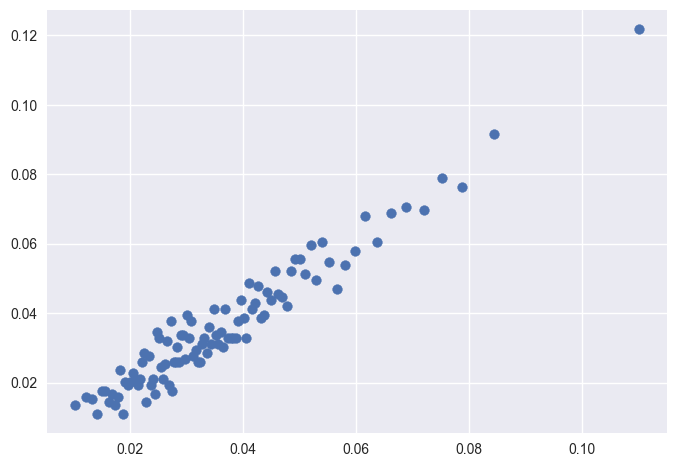

In [30]:
predicted_bins, actual_counters, counters = give_ece_data(predicts_calibrated.ravel(), 100, y_val.values)

plt.scatter(predicted_bins, actual_counters)
ece = 0
for i in range(100):
    ece +=  counters[i]*np.abs((predicted_bins[i] - actual_counters[i]))
ece /= len(y_val)
print(ece)

# Попробуем на тесте

In [31]:
indexes_test = TREE.apply(x_test.values.astype(np.float32))
predicts_from_model_test = model.predict_proba(x_test)[:, 1].reshape((-1, 1))

predicts_calibrated_test = np.zeros_like(predicts_from_model_test)
for node in tqdm(log_reg_dict.keys()):
    predicts_calibrated_test[indexes_test==node] = log_reg_dict[node].\
        predict_proba(transform(predicts_from_model_test[indexes_test==node]))[:, 1].reshape((-1, 1))

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=20, subsample_freq=0 will be ignored. Current value: bagging_freq=20


D:\Dev\jupyter\projects\Data Science\venvs\hardml\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: Found 'application' in params. Will use it instead of 'objective' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'objective' argument")
100%|████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 1082.84it/s]


0.004417809153761331


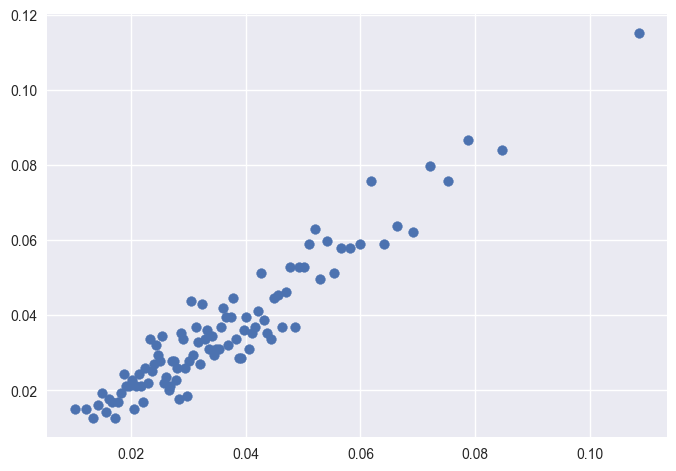

In [32]:
predicted_bins, actual_counters, counters = give_ece_data(predicts_calibrated_test.ravel(), 100, y_test.values)

plt.scatter(predicted_bins, actual_counters)
ece = 0
for i in range(100):
    ece +=  counters[i]*np.abs((predicted_bins[i] - actual_counters[i]))
ece /= len(y_test)
print(ece)

# Влияет ли как-то калибровка на наши метрики?

In [33]:
roc_auc_score(y_val, preds_val), roc_auc_score(y_val, predicts_calibrated.ravel())

(0.6296237390078979, 0.6333146423504677)

In [34]:
roc_auc_score(y_test, preds_test), roc_auc_score(y_test, predicts_calibrated_test.ravel())

(0.6299135699752826, 0.6283056918454213)